## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
#import gc
import random
#from glob import glob
#from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#import json
import re
import sys
import math
import string
#import joblib
import Levenshtein
import difflib
from sklearn.model_selection import train_test_split

# plotting
import seaborn as sns
from matplotlib import pyplot as plt


## To do list:
1. add more attributes (url, reviews)
2. add more features (embeddings)
3. hyperparameter tuning
4. datasets from mobi
5. k-fold
6. check test dataset

## I. Load datasets
- https://www.kaggle.com/code/ryotayoshinobu/foursquare-lightgbm-baseline#Search-Candidates
- https://www.kaggle.com/datasets/takoihiraokazu/foursquare-fold
- https://github.com/TakoiHirokazu/Kaggle-Foursquare-Location-Matching

In [3]:
#df_pairs = pd.read_csv("pairs.csv")
#len(df_pairs)

folders = ['train_all', 'train_all_filtercat', 'train_us', 'train_us_filtercat']

dfs = []

for f in folders:
    df_match= pd.read_csv("../1_datasets_fs/"+f+"/pairs_fs_match.csv")
    df_mismatch = pd.read_csv("../1_datasets_fs/"+f+"/pairs_fs_mismatch.csv")
    df_match = df_match.sample(n = len(df_mismatch))
    df = pd.concat([df_match, df_mismatch], axis=0).reset_index(drop=True)
    dfs.append(df)

## Attributes
- Name
- Coordinates
- Address
- Type

#### 1. Add Name Features
- Frequnecy counts (bag of words, n-grams, TF-IDF)
- String measures (Levenstein, Jaro/Jaro-Winkler, Hamming)
- Word Embedding (SBert, fastText)

In [4]:
%load_ext Cython

In [5]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]


In [6]:
def normalized_leven(s1, s2):
    maxlen = max(len(s1), len(s2));
    # normalize by length, high score wins
    return float(maxlen - Levenshtein.distance(s1, s2)) / float(maxlen);

# Create TfidfVectorizer object
vectorizer = TfidfVectorizer(binary=1)

# Sentence transformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [8]:
def add_name_features(df):
    
    # name1 vs. name2
    geshs = [] 
    levens = []
    jaros = []
    lcss = []
    tfidf = []
    embed = []
    
    for str1, str2 in df[[f"name1", f"name2"]].values.astype(str):
        # string measures
        geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())     
        levens.append(normalized_leven(str1, str2))
        jaros.append(Levenshtein.jaro_winkler(str1, str2))
        lcss.append(LCS(str(str1), str(str2)))
       
        # TF-IDF
        # Generate matrix of word vectors
        if str1==str2:
            tfidf.append(1.0)
        else:
            str1 = remove_punctuation(str1)
            str2 = remove_punctuation(str2)
            m = vectorizer.fit_transform([str1, str2])
            # compute and print the cosine similarity matrix
            cosine_sim = cosine_similarity(m, m)
            tfidf.append(cosine_sim[0][1])
        
        # SBert
        corpus_embeddings = embedder.encode([str1], convert_to_tensor=True)
     #   corpus_embeddings = util.normalize_embeddings(corpus_embeddings)
        query_embedding = embedder.encode([str2], convert_to_tensor=True)
     #   query_embedding = util.normalize_embeddings(query_embedding)
        cos_score = util.cos_sim(query_embedding, corpus_embeddings)[0]
        embed.append(float(cos_score))

    df[f"name_gesh"] = geshs
    df[f"name_leven"] = levens
    df[f"name_jaro"] = jaros
    df[f"name_lcss"] = lcss
    df[f"name_tfidf"] = tfidf
    df[f"name_embed"] = embed
       
    return df

#### 2. Add Distance Features
- Spatial distance (euclidean distance, geodesic distance)
- Distance Embedding 

In [9]:
def add_distance_features(df):
     
    eucd = []
    geod = []

    for x1, y1, x2, y2 in df[[f"lat1", f"lon1", f"lat2", f"lon2"]].values.astype(float):

        # euclidean distance
        P1 = np.array((x1, y1))
        P2 = np.array((x2, y2))
        # subtracting both the vectors
        temp = P1 - P2
        eucd.append(np.sqrt(np.dot(temp.T, temp)))
        
        # geodesic distance
        geod.append(geodesic(P1, P2).km)

    df[f"dist_eucd"] = eucd
    df[f"dist_geod"] = geod

    return df

#### 3. Add Address Features
- String measures (Levenstein, Jaro/Jaro-Winkler, Hamming)
- Address elements

In [10]:
def add_address_features(df):
    
    # addr1 vs. addr2
    geshs = [] 
    levens = []
    jaros = []
    lcss = []
    tfidf = []
    embed = []
    
    for str1, str2 in df[[f"addr1", f"addr2"]].values.astype(str):
        geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())     
        levens.append(normalized_leven(str1, str2))
        jaros.append(Levenshtein.jaro_winkler(str1, str2))
        lcss.append(LCS(str(str1), str(str2)))
        
        # TF-IDF
        # Generate matrix of word vectors
        if str1==str2:
            tfidf.append(1.0)
        else:
            str1 = remove_punctuation(str1)
            str2 = remove_punctuation(str2)
        
            # TF-IDF
            # Generate matrix of word vectors
            m = vectorizer.fit_transform([str1, str2])
            # compute and print the cosine similarity matrix
            cosine_sim = cosine_similarity(m, m)
            tfidf.append(cosine_sim[0][1])

        # SBert
        corpus_embeddings = embedder.encode([str1], convert_to_tensor=True)
     #   corpus_embeddings = util.normalize_embeddings(corpus_embeddings)
        query_embedding = embedder.encode([str2], convert_to_tensor=True)
     #   query_embedding = util.normalize_embeddings(query_embedding)
        cos_score = util.cos_sim(query_embedding, corpus_embeddings)[0]
        embed.append(float(cos_score))

    df[f"addr_gesh"] = geshs
    df[f"addr_leven"] = levens
    df[f"addr_jaro"] = jaros
    df[f"addr_lcss"] = lcss
    df[f"addr_tfidf"] = tfidf
    df[f"addr_embed"] = embed     
       
    return df

#### 4. Add Type Features
- WordNet
- Unified POI type
- Type Embedding

In [11]:
for i, df in enumerate(dfs):
    print(i)
    df = add_name_features(df)
    df = add_distance_features(df)
    df = add_address_features(df)

0
1
2
3


In [12]:
# save to csv
for i, df in enumerate(dfs):
    df.to_csv(folders[i]+".csv")

## II. EDA

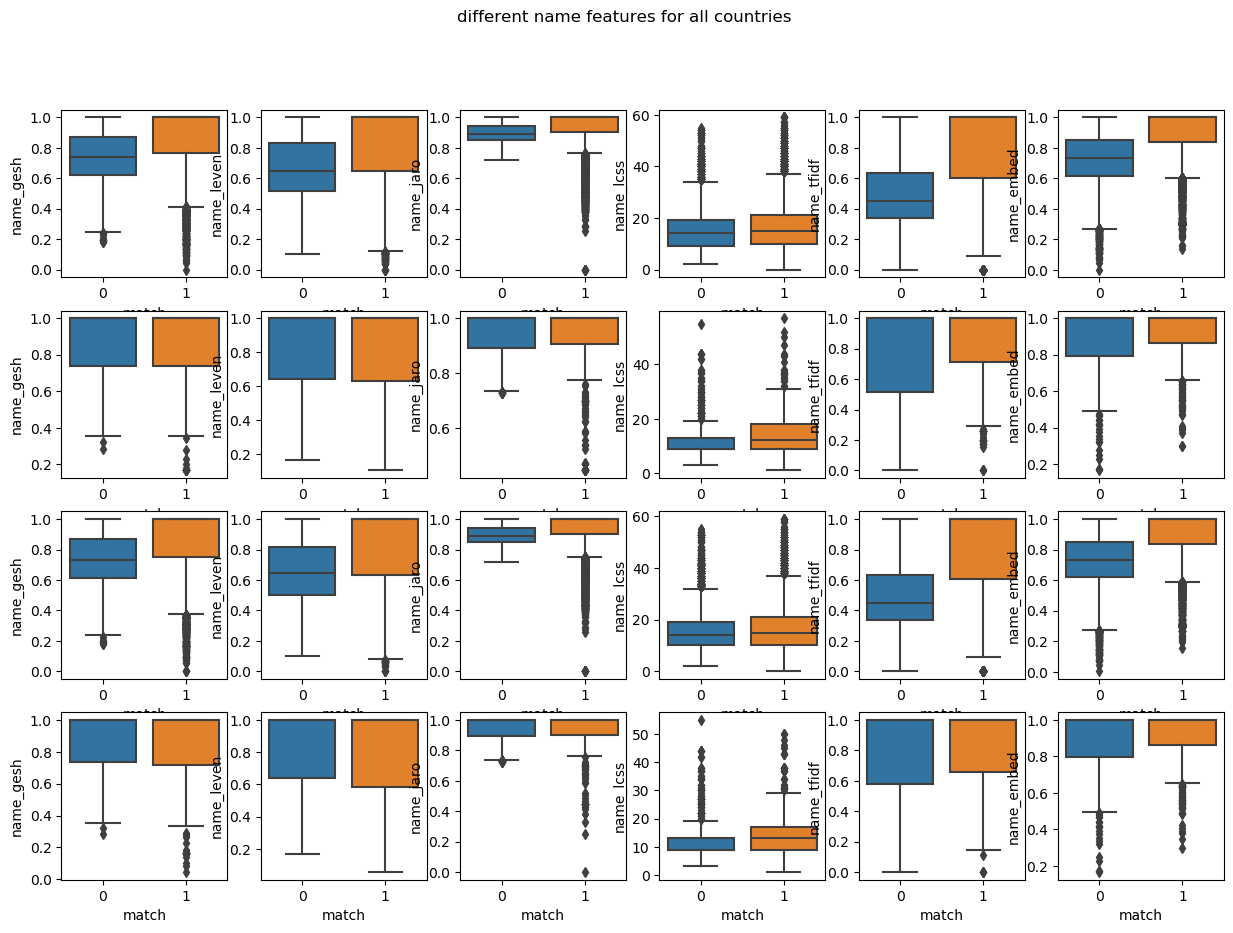

In [13]:
# compare different name features for all countries
%matplotlib inline
fig, axes = plt.subplots(4, 6, figsize=(15, 10))
fig.suptitle('different name features for all countries')

for i in range(4):
    sns.boxplot(ax=axes[i, 0], data=dfs[i], x='match', y='name_gesh')
    sns.boxplot(ax=axes[i, 1], data=dfs[i], x='match', y='name_leven')
    sns.boxplot(ax=axes[i, 2], data=dfs[i], x='match', y='name_jaro')
    sns.boxplot(ax=axes[i, 3], data=dfs[i], x='match', y='name_lcss')
    sns.boxplot(ax=axes[i, 4], data=dfs[i], x='match', y='name_tfidf')
    sns.boxplot(ax=axes[i, 5], data=dfs[i], x='match', y='name_embed')


NOTES:
- Filter categories make features undistinguishable.
- Using all countries vs. us only does not differ very much.
- if not fitler categories, useful features are gesh, leven, jaro, tiff and embed

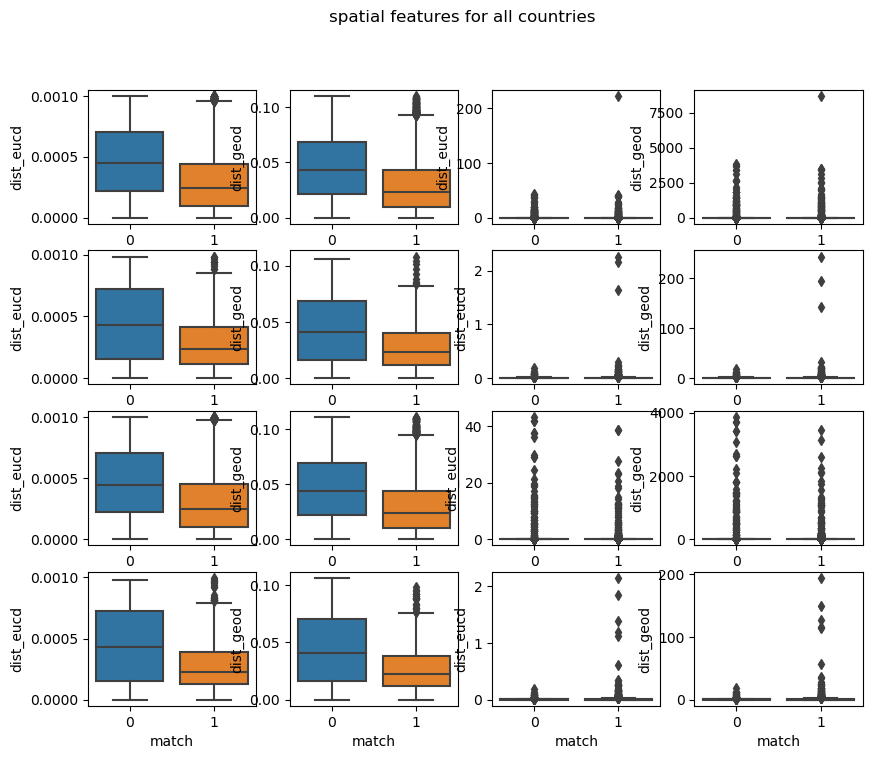

In [14]:
# compare different spatial features for all countries
%matplotlib inline
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
fig.suptitle('spatial features for all countries')

for i in range(4):
    # draw lineplot 
    tmp = dfs[i].copy()
    tmp = tmp[tmp['dist_eucd']<0.001]
    sns.boxplot(ax=axes[i, 0], data=tmp, x='match', y='dist_eucd')
    sns.boxplot(ax=axes[i, 1], data=tmp, x='match', y='dist_geod')
    sns.boxplot(ax=axes[i, 2], data=dfs[i], x='match', y='dist_eucd')
    sns.boxplot(ax=axes[i, 3], data=dfs[i], x='match', y='dist_geod')


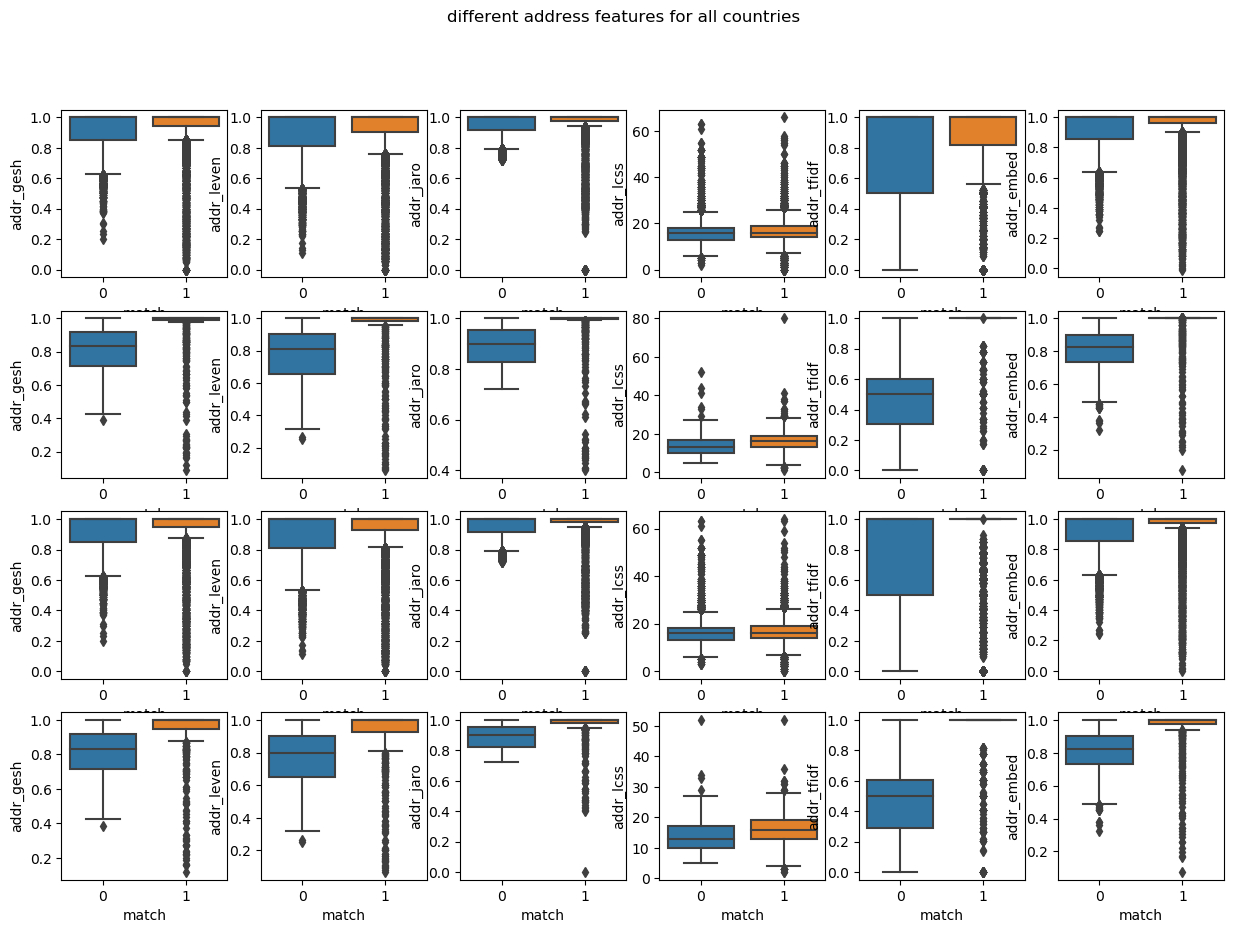

In [44]:
# compare different address features for all countries
%matplotlib inline
fig, axes = plt.subplots(4, 6, figsize=(15, 10))
fig.suptitle('different address features for all countries')

for i in range(4):
    sns.boxplot(ax=axes[i, 0], data=dfs[i], x='match', y='addr_gesh')
    sns.boxplot(ax=axes[i, 1], data=dfs[i], x='match', y='addr_leven')
    sns.boxplot(ax=axes[i, 2], data=dfs[i], x='match', y='addr_jaro')
    sns.boxplot(ax=axes[i, 3], data=dfs[i], x='match', y='addr_lcss')
    sns.boxplot(ax=axes[i, 4], data=dfs[i], x='match', y='addr_tfidf')
    sns.boxplot(ax=axes[i, 5], data=dfs[i], x='match', y='addr_embed')

